In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import skmob
import osmnx as ox  # version '0.16.0' or greater
import mobair as mb

## Plotting the CCDF of the data
Code for obtaining the __Supplementary Figures 1-2__.

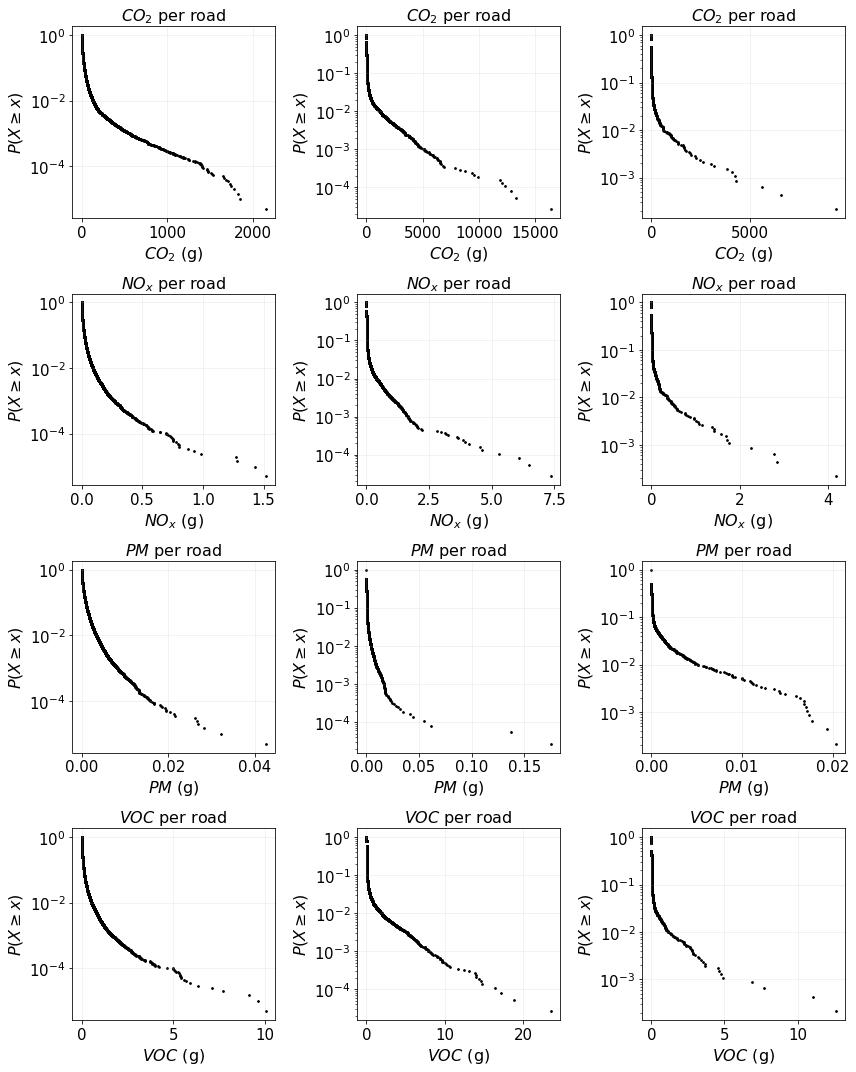

In [7]:
import matplotlib.pyplot as plt
from powerlaw import ccdf

# choose the type of distribution of emissions: per vehicle / per road 
dist_type = 'road'  # one of {'vehicle', 'road'}

list__tuple_city_pollutant = [
    ('Greater London', 'CO_2'), ('Rome', 'CO_2'), ('Florence', 'CO_2'), 
    ('Greater London', 'NO_x'), ('Rome', 'NO_x'), ('Florence', 'NO_x'), 
    ('Greater London', 'PM'), ('Rome', 'PM'), ('Florence', 'PM'), 
    ('Greater London', 'VOC'), ('Rome', 'VOC'), ('Florence', 'VOC'), 
]


fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 15))

for ax, (city_name, c_pollutant) in zip(axs.flat, list__tuple_city_pollutant):
    
    # loading df
    df = pd.read_csv('./data/cumulate_emissions_per_%s__%s.csv' %(dist_type, city_name.lower().replace(' ', '_')), index_col=0)
    # tacking the column with the current pollutant
    list_cumulate_emissions = list(df[c_pollutant])
    
    # using powerlaw package to compute the CCDF of the current distribution
    x, y = ccdf(list_cumulate_emissions, linear_bins=False)
    
    # plotting
    ax.scatter(x, y, color='black', s=3, label='data')
    ax.set_xlabel(r'$%s$ (g)' %c_pollutant, fontsize=16)
    ax.set_ylabel(r'$P(X \geq x)$', fontsize=16)
    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_yscale('log')
    ax.set_title(r'$%s$ per %s' %(c_pollutant, dist_type), fontsize=16)
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

## Plotting the Lorenz curves
Code for obtaining the __Supplementary Figure 5__.

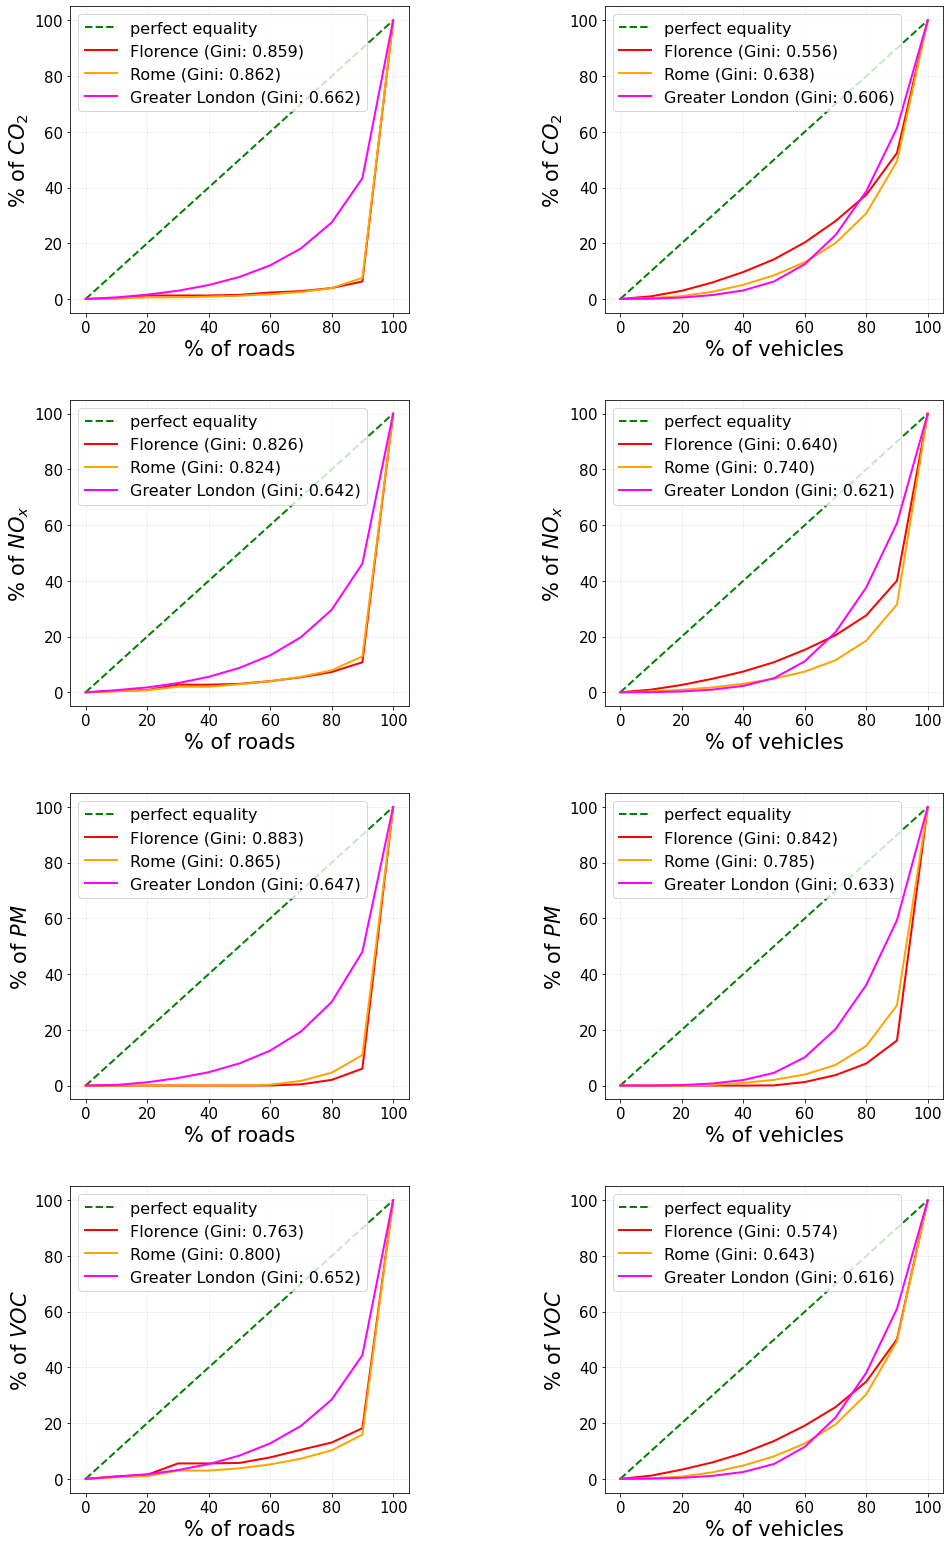

In [21]:
import matplotlib.pyplot as plt
import numpy as np

list__tuple_dist_pollutant = [
    ('roads', 'CO_2'), ('vehicles', 'CO_2'),
    ('roads', 'NO_x'), ('vehicles', 'NO_x'),
    ('roads', 'PM'), ('vehicles', 'PM'),
    ('roads', 'VOC'), ('vehicles', 'VOC'),
]
map__city__color = {'Florence' : 'red',
                    'Rome' : 'orange',
                    'Greater London' : 'magenta'}

####
# defining the function used for computing the curve and the Gini coefficient
def Lorenz(v, bins):
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return yvals, gini_val
####


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 22))

for ax, (dist_type, c_pollutant) in zip(axs.flat, list__tuple_dist_pollutant):
    
    # plotting line of perfect equality
    bins = np.linspace(0., 100., 11)
    ax.plot(bins, bins, '--', label="perfect equality", color='green', linewidth=2)
    
    for city_name in ['Florence', 'Rome', 'Greater London']:
        # loading df
        df = pd.read_csv('./data/cumulate_emissions_per_%s__%s.csv' %(dist_type[:-1], city_name.lower().replace(' ', '_')), index_col=0)
        # tacking the column with the current pollutant
        list_cumulate_emissions = list(df[c_pollutant])
        
        # plotting Lorenz curve for current city
        result, gini_val = Lorenz(np.array(list_cumulate_emissions), bins)
        ax.plot(bins, result, label='%s (Gini: %.3f)' %(city_name, gini_val), color=map__city__color[city_name], linewidth=2)
        
    ax.set_xlabel(r'%% of %s' %dist_type, fontsize=21)
    ax.set_ylabel(r'%% of $%s$' %c_pollutant, fontsize=21)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(alpha=0.2)
    ax.legend(fontsize=16)

plt.subplots_adjust(wspace = 5, hspace = 4)
plt.tight_layout()
plt.show()

## Fitting of distributions
Code for obtaining the __Figures 2b,c,e,f,h,i__ and __Supplementary Figures 3-4 and 6-7__, and for __Tables 2-6__.

The methods used are all in ```fitting.py```, and can be used here to fit and plot _one single_ distribution (i.e. of one type - per vehicle/road -, for one pollutant, and for one city)

-- Fitting distribution per vehicle --
num points :  3962


/home/matteo/anaconda3/envs/skmob/lib/python3.7/site-packages/powerlaw-1.4.4-py3.7.egg/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide


fixed xmin:  False


Assuming nested distributions
Assuming nested distributions


Best fit(s) :  ['truncated_power_law']
-- end --


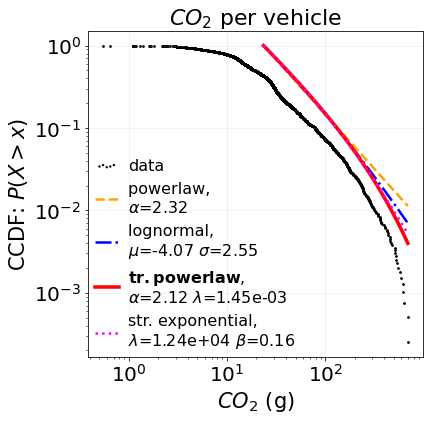

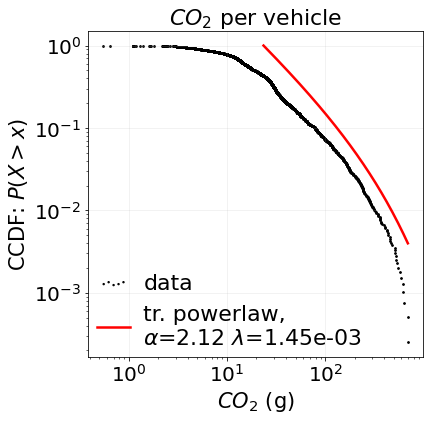

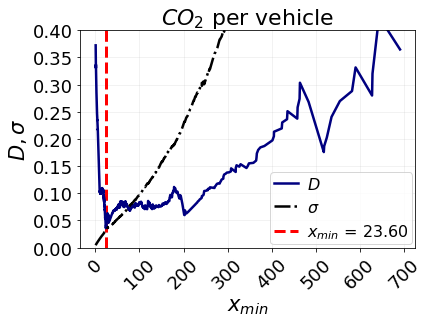

In [43]:
from fitting import *
import pandas as pd

# define the city, pollutant and type of distribution that one wants to fit
city_name = 'Rome'
pollutant = 'CO_2'
dist_type = 'per road'

# loading df
df = pd.read_csv('./data/cumulate_emissions_per_%s__%s.csv' %(dist_type[4:], city_name.lower().replace(' ', '_')), index_col=0)
# tacking the column with the current pollutant
list_cumulate_emissions = list(df[pollutant])

map__dist_type__distribution = {
    dist_type : list_cumulate_emissions,
}

map__dist_type__fitting_results, map__dist_type__comparison_results = fit_powerlaw(map__dist_type__distribution,
                                                                                   city_name,
                                                                                   pollutant, xmin=None,
                                                                                   sigma_threshold=0.05,
                                                                                   list_distributions_to_fit=[
                                                                                       'power_law', 'lognormal',
                                                                                       'exponential',
                                                                                       'truncated_power_law',
                                                                                       'stretched_exponential'],
                                                                                   plot_ccdf=True,
                                                                                   plot_pdf=False,
                                                                                   plot_xmin=True,
                                                                                   x_label=r'$%s$ (g)' %pollutant, 
                                                                                   single_fit_to_plot='truncated_power_law', 
                                                                                   save_figures=False)

The following is the code for visualizing the results of the log-likelihood ratio tests in a table (like the paper's __Tables 2-6__).

In [45]:
import pandas as pd

map__couple__results = map__dist_type__comparison_results[dist_type]

list_distrib = ['power_law', 'lognormal', 'truncated_power_law', 'stretched_exponential', 'exponential']
df_results = pd.DataFrame(index=list_distrib, columns=list_distrib)

map__distrib__name = {
    'power_law' : 'power-law', 
    'lognormal' : 'lognormal', 
    'truncated_power_law' : 'tr. power-law', 
    'stretched_exponential' : 'str. exponential', 
    'exponential' : 'exponential',
    None : 'None'
}

for couple, result in map__couple__results.items():
    if result['best_fit'] != None:
        label = map__distrib__name[result['best_fit']] + ' (R=%.2f, p=%.2f)' %(result['R'], result['p'])
    else:
        label = map__distrib__name[result['best_fit']]

    if (couple[0] == 'exponential') and ((couple[1] == 'truncated_power_law') or (couple[1] == 'stretched_exponential')):
        if result['best_fit'] != None:
            label = map__distrib__name[result['best_fit']] + ' (R=%.2f, p=%.2f)' %(-result['R'], result['p'])
        else:
            label = map__distrib__name[result['best_fit']]
        df_results.loc[couple[1], couple[0]] = label
    else:
        df_results.loc[couple[0], couple[1]] = label
    
df_results.index = [map__distrib__name[distrib] for distrib in df_results.index]
df_results.columns = [map__distrib__name[distrib] for distrib in df_results.columns]
df_results.fillna('-')

,power-law,lognormal,tr. power-law,str. exponential,exponential
power-law,-,"lognormal (R=-2.07, p=0.04)","tr. power-law (R=-3.96, p=0.00)",None,"power-law (R=10.23, p=0.00)"
lognormal,-,-,"tr. power-law (R=-6.59, p=0.00)",None,"lognormal (R=10.99, p=0.00)"
tr. power-law,-,-,-,"tr. power-law (R=6.79, p=0.00)","tr. power-law (R=11.36, p=0.00)"
str. exponential,-,-,-,-,"str. exponential (R=11.36, p=0.00)"
exponential,-,-,-,-,-


## Simulation scenarios
Code for obtaining the __Figures 3e,f__ and __Supplementary Figures 14-15__.

### Electrification scenario

In [3]:
import random
import numpy as np
import pandas as pd

# define the city and pollutant for which one wants the simulation
city_name = 'Municipio Roma II'  #one of {'Florence', 'Rome', 'Greater London', 'Municipio Roma II'}
pollutant = 'CO_2'

# loading df
df = pd.read_csv('./data/cumulate_emissions_per_vehicle__%s.csv' %(city_name.lower().replace(' ', '_')), index_col=0)
# creating a dictionary that maps each vehicle to its total emissions
map__vehicle__tot_emissions = dict(zip(df['uid'], df[pollutant]))

# creating a dictionary that maps each choice ('most polluting' or 'random') to the % reduction of the emissions 
# obtained by electrifying 0 to 99% (1%-step) of the vehicles chosen in decreasing order starting from the 'most polluting' or chosen at 'random'
map__vehicle_choice__x_percent_reduction_perc = {}
for c_choice in ['most polluting', 'random']:
    
    sum_tot_emissions = sum(map__vehicle__tot_emissions.values())
    num_vehicles = len(map__vehicle__tot_emissions.keys())
    
    map__x_percent__emissions_reduction_perc = {0 : 0}
    map__x_percent__tot_emissions_distribution = {0 : list(map__vehicle__tot_emissions.values())}
    
    for x_percent in np.arange(1,100,step=1):
        
        num_vehicles_x_percent = int(num_vehicles / 100 * x_percent)
        
        if c_choice == 'most polluting':
            map__x_percent_vehicles__tot_emissions = {uid : tot_emissions for uid,tot_emissions in sorted(map__vehicle__tot_emissions.items(), key=lambda item: item[1], reverse=True)[0:num_vehicles_x_percent]}
        else:
            random.seed(4)  # this is the seed used for the paper's experiments
            set_random_vehicles = set(random.sample(map__vehicle__tot_emissions.keys(), num_vehicles_x_percent))
            map__x_percent_vehicles__tot_emissions = {uid : tot_emissions for uid,tot_emissions in sorted(map__vehicle__tot_emissions.items(), key=lambda item: item[1], reverse=True) if uid in set_random_vehicles}
        
        ## percent emissions reduction
        sum_x_percent_tot_emissions = sum(map__x_percent_vehicles__tot_emissions.values())
        emissions_reduction_perc = sum_x_percent_tot_emissions / sum_tot_emissions * 100
        map__x_percent__emissions_reduction_perc[x_percent] = emissions_reduction_perc
        
        map__vehicle_choice__x_percent_reduction_perc[c_choice] = map__x_percent__emissions_reduction_perc

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit

### defining the Generalised Logistic Function (Richard's curve)
import numpy as np
def richard(time, alpha, beta, rate, slope):
    """
    Computes the Richard growth model
    Parameters
    ----------
    time : time
    alpha : upper asymptote
    beta : growth range
    rate : growth rate
    slope : slope of growth

    References
    ----------
    .. [1] F. J. Richards, "A flexible growth function for empirical use", Journal of Experimental Botany, 
        vol. 10, no. 29, pp. 290–300, 1959.
    .. [2] D. Fekedulegn, M. Mac Siurtain, and J. Colbert, "Parameter estimation
            of nonlinear growth models in forestry," Silva Fennica, vol. 33, no.
            4, pp. 327-336, 1999.
    """

    y = (1 + beta * np.exp(-rate * time)) ** (1 / slope)
    y = alpha / y
    
    return y
###

### defining a method to plot the emissions reduction curves together with the Richard's curve fit
def line_plotter_with_fit(map__feature__x_y, x_label, y_label, map__feature__plot_feature__value, region_name, save_fig=False):
    
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(1, 1, 1)
    
    # inset axes...
    axins = ax.inset_axes([0.68, 0.07, 0.6, 0.6])

    for c_feature in map__feature__x_y:
        
        data = [y for x,y in sorted(map__feature__x_y[c_feature].items())]
        x = np.array([x for x,y in sorted(map__feature__x_y[c_feature].items())])
    
        if any(isinstance(el, list) for el in data):  # if the elements of data are lists (i.e. if, for each x, the element is not a single value but a distribution...)
            y = np.array([np.median(distrib) for distrib in data])
            first_quartiles = np.array([np.quantile(distrib, 0.25) for distrib in data])
            third_quartiles = np.array([np.quantile(distrib, 0.75) for distrib in data])
        else:
            y = np.array(data)


        ax.plot(x, y, 
                color=map__feature__plot_feature__value[c_feature]['color'], #'#D7191C'
                linestyle=map__feature__plot_feature__value[c_feature]['lstyle'],
                linewidth=3, alpha=1,
                label=map__feature__plot_feature__value[c_feature]['name'], #'most polluting'
               )
        axins.plot(x, y, 
                  color=map__feature__plot_feature__value[c_feature]['color'], #'#D7191C'
                  linestyle=map__feature__plot_feature__value[c_feature]['lstyle'],
                  linewidth=3, alpha=1,
                  label=map__feature__plot_feature__value[c_feature]['name'], #'most polluting'
                )
    
        if any(isinstance(el, list) for el in data):
            ax.fill_between(x, third_quartiles, first_quartiles, alpha=0.125, 
                            facecolor=map__feature__plot_feature__value[c_feature]['color'])

        if c_feature == 'most polluting':
            ## fitting a generalised logistic function to the "decreasing order" curve
            # starting values for the parameters (following [2] Fekedulegn et al. 1999):
            map__city__initial_guess = {
                'Florence' : [100, 1, 1/100, 1],
                'Rome' : [100, 0, 1/100, 1],
                'Greater London' : [100, 0, 1/100, 1],
                'Municipio Roma II' : [100, 1, 1/100, 1]
            }
            pars_0 = map__city__initial_guess[region_name]
            pars, pcov = curve_fit(richard, x, y, p0 = pars_0, method='lm')
            print('Est. paramenters: ', pars)
            y_pred = richard(x, pars[0], pars[1], pars[2], pars[3])
            residuals = y - y_pred
            ss_res = np.sum((y - y_pred)**2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            print('R squared : %s' %r2)
            ax.plot(x, y_pred, color='red', linewidth=4, linestyle=':', label='gen. logistic fit')
            axins.plot(x, y_pred, color='red', linewidth=4, linestyle=':', label='gen. logistic fit')

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    x_ticks = np.arange(0,110,step=10)
    plt.xticks(x_ticks, rotation=0, fontsize=16)  ##########
    plt.yticks(fontsize=16)
    
    ax.set_xlabel(x_label, size='large', fontsize=18)
    ax.set_ylabel(y_label, size='large', fontsize=18)
    
    plt.legend(loc='upper left', fontsize=16, framealpha=0.6, handlelength=1.5, bbox_to_anchor=(1.02, 0))
    plt.grid(alpha=0.5)
    plt.title(region_name, fontsize=18)
    #

    # sub region of the original image
    x1, x2, y1, y2 = 0, 10, 0, 53
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.grid(alpha=0.5)
    axins.xaxis.set_major_locator(MaxNLocator(integer=True))
    #
    #ax.indicate_inset_zoom(axins, edgecolor='black', linestyle='--')


    if save_fig:
        plot_file_name = "plot_lines__electrification_simulation__" + pollutant + '__emissions_reduction__'+str(region_name).replace(' ','_').lower()+'__with_fit.png'
        plt.savefig(plot_file_name, dpi=300, bbox_inches='tight')
        plt.clf()
        plt.close()
    else:
        plt.show()
    #
    return
###

/home/matteo/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in power


Est. paramenters:  [ 9.97731121e+01 -9.99999999e-01  4.84394010e-02 -1.54956892e+00]
R squared : 0.9988388411128145


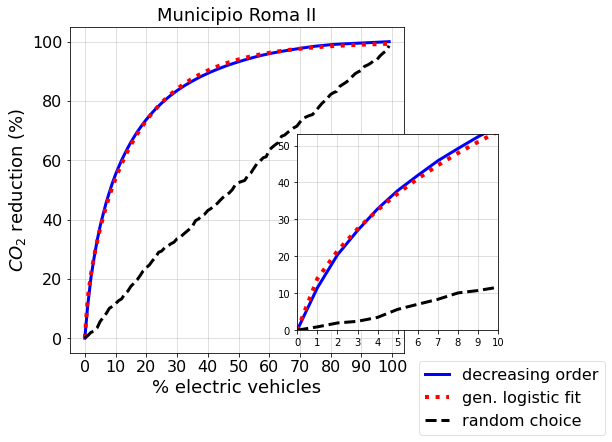

In [11]:
map__vehicle_choice__plot_feature__value = {
    'most polluting' : {'name' : 'decreasing order',
                       'color' : 'blue',
                        'lstyle' : '-'},
    'random' : {'name' : 'random choice',
               'color' : 'black',
                'lstyle' : '--'}
}

line_plotter_with_fit(map__vehicle_choice__x_percent_reduction_perc, 
                      '% electric vehicles', r'$CO_2$ reduction (%)', 
                      map__vehicle_choice__plot_feature__value, city_name, save_fig=False)

### Home working scenario

In [40]:
import random
import numpy as np
import pandas as pd

# define the city and pollutant for which one wants the simulation
city_name = 'Rome'  #one of {'Florence', 'Rome', 'Greater London'}
pollutant = 'CO_2'

# loading df
df = pd.read_csv('./data/cumulate_emissions_per_vehicle__%s.csv' %(city_name.lower().replace(' ', '_')), index_col=0)
# creating a dictionary that maps each vehicle to its total emissions
map__vehicle__tot_emissions = dict(zip(df['uid'], df[pollutant]))
sum_tot_emissions = sum(map__vehicle__tot_emissions.values())
num_vehicles = len(map__vehicle__tot_emissions.keys())

# loading df with commuting trajectories
df_commuting = pd.read_csv('./data/cumulate_emissions_per_vehicle_from_commuting_traj__%s.csv' %(city_name.lower().replace(' ', '_')), index_col=0)
# creating a dictionary that maps each vehicle to its total emissions
map__commuters__tot_emissions = dict(zip(df_commuting['uid'], df_commuting[pollutant]))
sum_commuting_emissions = sum(map__commuters__tot_emissions.values())
set_commuters = set(map__commuters__tot_emissions.keys())
num_commuters = len(set_commuters)

# creating a dictionary that maps each choice ('most polluting' or 'random') to the % reduction of the emissions 
# obtained with the stop of commuting of the vehicles chosen in decreasing order starting from the 'most polluting' or chosen at 'random'
map__vehicle_choice__x_percent_reduction_perc = {}
for c_choice in ['most polluting', 'random']:
    
    map__x_percent__emissions_reduction_perc = {0 : 0}
    map__x_percent__tot_emissions_distribution = {0 : list(map__vehicle__tot_emissions.values())}
    
    for x_percent in np.arange(1,101,step=1):
        
        num_commuters_x_percent = int(num_commuters / 100 * x_percent)
        perc_commuters_over_total = num_commuters_x_percent / num_vehicles * 100
        
        if c_choice == 'most polluting':
            map__x_percent_gross_polluters_that_are_commuters__tot_emissions = {uid : tot_emissions for uid,tot_emissions in sorted(map__vehicle__tot_emissions.items(), key=lambda item: item[1], reverse=True) if uid in map__commuters__tot_emissions.keys()}
            map__x_percent_commuters__tot_emissions = {uid : map__commuters__tot_emissions[uid] for uid,tot_emissions in sorted(map__x_percent_gross_polluters_that_are_commuters__tot_emissions.items(), key=lambda item: item[1], reverse=True)[0:num_commuters_x_percent]}
        else:
            random.seed(4)
            set_random_commuters = set(random.sample(set_commuters, num_commuters_x_percent))
            map__x_percent_commuters__tot_emissions = {uid : tot_emissions for uid,tot_emissions in sorted(map__commuters__tot_emissions.items(), key=lambda item: item[1], reverse=True) if uid in set_random_commuters}
        
        ## percent emissions reduction
        sum_x_percent_tot_emissions = sum(map__x_percent_commuters__tot_emissions.values())
        emissions_reduction_perc = sum_x_percent_tot_emissions / sum_tot_emissions * 100
        map__x_percent__emissions_reduction_perc[perc_commuters_over_total] = emissions_reduction_perc
        
        map__vehicle_choice__x_percent_reduction_perc[c_choice] = map__x_percent__emissions_reduction_perc

print('Number of commuters: %s (%.2f %% of total)' %(num_commuters, num_commuters/num_vehicles * 100))
perc_emissions_from_commuting = sum_commuting_emissions/sum_tot_emissions * 100
print('Perc of emissions coming from commuting: ', perc_emissions_from_commuting)

Number of commuters: 2495 (30.55 % of total)
Perc of emissions coming from commuting:  16.78068431494173


In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit

### defining the Generalised Logistic Function (Richard's curve)
import numpy as np
def richard(time, alpha, beta, rate, slope):
    """
    Computes the Richard growth model
    Parameters
    ----------
    time : time
    alpha : upper asymptote
    beta : growth range
    rate : growth rate
    slope : slope of growth

    References
    ----------
    .. [1] F. J. Richards, "A flexible growth function for empirical use", Journal of Experimental Botany, 
        vol. 10, no. 29, pp. 290–300, 1959.
    .. [2] D. Fekedulegn, M. Mac Siurtain, and J. Colbert, "Parameter estimation
            of nonlinear growth models in forestry," Silva Fennica, vol. 33, no.
            4, pp. 327-336, 1999.
    """

    y = (1 + beta * np.exp(-rate * time)) ** (1 / slope)
    y = alpha / y
    
    return y
###

### defining a method to plot the emissions reduction curves together with the Richard's curve fit
def line_plotter_with_fit(map__feature__x_y, x_label, y_label, map__feature__plot_feature__value, region_name, save_fig=False):
    
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(1, 1, 1)

    for c_feature in map__feature__x_y:
        
        data = [y for x,y in sorted(map__feature__x_y[c_feature].items())]
        x = np.array([x for x,y in sorted(map__feature__x_y[c_feature].items())])
    
        if any(isinstance(el, list) for el in data):  # if the elements of data are lists (i.e. if, for each x, the element is not a single value but a distribution...)
            y = np.array([np.median(distrib) for distrib in data])
            first_quartiles = np.array([np.quantile(distrib, 0.25) for distrib in data])
            third_quartiles = np.array([np.quantile(distrib, 0.75) for distrib in data])
        else:
            y = np.array(data)


        ax.plot(x, y, 
                color=map__feature__plot_feature__value[c_feature]['color'], #'#D7191C'
                linestyle=map__feature__plot_feature__value[c_feature]['lstyle'],
                linewidth=3, alpha=1,
                label=map__feature__plot_feature__value[c_feature]['name'], #'most polluting'
               )
    
        if any(isinstance(el, list) for el in data):
            ax.fill_between(x, third_quartiles, first_quartiles, alpha=0.125, 
                            facecolor=map__feature__plot_feature__value[c_feature]['color'])

        if c_feature == 'most polluting':
            ## fitting a generalised logistic function to the "decreasing order" curve
            # starting values for the parameters (following [2] Fekedulegn et al. 1999):
            # (the initial guess for the first parameter, alpha_0, is the upper asymptote to the growth, 
            # that, in our context, is equal to the tot % of emissions coming from commuting in that city)
            map__city__initial_guess = {
                'Florence' : [perc_emissions_from_commuting, 1, 1/perc_emissions_from_commuting, 1],
                'Rome' : [perc_emissions_from_commuting, 0, 1/perc_emissions_from_commuting, 1],
                'Greater London' : [perc_emissions_from_commuting, 1, 1/perc_emissions_from_commuting, 1],
            }
            pars_0 = map__city__initial_guess[region_name]
            pars, pcov = curve_fit(richard, x, y, p0 = pars_0, method='lm')
            print('Est. paramenters: ', pars)
            y_pred = richard(x, pars[0], pars[1], pars[2], pars[3])
            residuals = y - y_pred
            ss_res = np.sum((y - y_pred)**2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            print('R squared : %s' %r2)
            label_pars = r'$\alpha=%.2f$, $\beta=%.2f$,' %(pars[0], pars[1]) +'\n'+ r'$r=%.2f$, $\nu=%.2f$' %(pars[2], pars[3])
            ax.plot(x, y_pred, color='red', linewidth=4, linestyle=':', label='gen. logistic fit \n'+label_pars) ## label with est. parameters
            #ax.plot(x, y_pred, color='red', linewidth=4, linestyle=':', label='gen. logistic fit')  ## label without est. parameters

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.xticks(rotation=0, fontsize=16)  ##########
    plt.yticks(fontsize=16)
    
    ax.set_xlabel(x_label, size='large', fontsize=18)
    ax.set_ylabel(y_label, size='large', fontsize=18)
    
    plt.legend(loc='lower right', fontsize=16, framealpha=0.6, handlelength=1.5)
    plt.grid(alpha=0.5)
    plt.title(region_name, fontsize=18)
    #

    if save_fig:
        plot_file_name = "plot_lines__smartworking_simulation__" + pollutant + '__emissions_reduction__'+str(region).replace(' ','_').lower()+'__with_fit.png'
        plt.savefig(plot_file_name, dpi=300, bbox_inches='tight')
        plt.clf()
        plt.close()
    else:
        plt.show()
    #
    return
###

/home/matteo/anaconda3/envs/skmob/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in power


Est. paramenters:  [17.12279332 -1.          0.1192129  -1.29902361]
R squared : 0.999777311680471


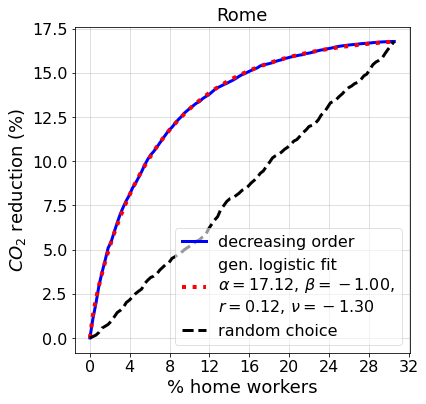

In [42]:
map__vehicle_choice__plot_feature__value = {
    'most polluting' : {'name' : 'decreasing order',
                       'color' : 'blue',
                        'lstyle' : '-'},
    'random' : {'name' : 'random choice',
               'color' : 'black',
                'lstyle' : '--'}
}

line_plotter_with_fit(map__vehicle_choice__x_percent_reduction_perc, 
                      '% home workers', r'$CO_2$ reduction (%)', 
                      map__vehicle_choice__plot_feature__value, city_name, save_fig=False)